<a href="https://colab.research.google.com/github/callezenwaka/facebook-pytorch/blob/main/capstone-project-1/transfer_learning_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
# define mean and std
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

In [3]:
# download dataset
!wget https://github.com/callezenwaka/facebook-pytorch/blob/main/capstone-project-1/data.zip?raw=true && unzip -qq data.zip?raw=true
!rm -rf data.zip?raw=true

--2021-10-19 05:21:08--  https://github.com/callezenwaka/facebook-pytorch/blob/main/capstone-project-1/data.zip?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/callezenwaka/facebook-pytorch/raw/main/capstone-project-1/data.zip [following]
--2021-10-19 05:21:09--  https://github.com/callezenwaka/facebook-pytorch/raw/main/capstone-project-1/data.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/callezenwaka/facebook-pytorch/main/capstone-project-1/data.zip [following]
--2021-10-19 05:21:09--  https://raw.githubusercontent.com/callezenwaka/facebook-pytorch/main/capstone-project-1/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubuserco

# Data Transformations

In [4]:
# # define training and test data directories
# data_dir = 'data/'
# train_dir = os.path.join(data_dir, 'train/')
# test_dir = os.path.join(data_dir, 'val/')

In [ ]:
# # load and transform data using ImageFolder

# # resize all images
# train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
#                                       transforms.RandomHorizontalFlip(),
#                                       transforms.ToTensor(),
#                                       transforms.Normalize(mean, std)
#                                       ])
# train_data = datasets.ImageFolder(train_dir, transform=train_transform)


# test_transform = transforms.Compose([transforms.Resize(256),
#                                      transforms.CenterCrop(224),
#                                      transforms.ToTensor(),
#                                      transforms.Normalize(mean, std)
#                                      ])
# test_data = datasets.ImageFolder(test_dir, transform=test_transform)

# # print out some data stats
# print('Num training images: ', len(train_data))
# print('Num test images: ', len(test_data))

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [ ]:
#
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device

In [6]:
# classes = train_data.classes
# classes

['ants', 'bees']

# DataLoaders and Data Visualization

In [7]:
# # define dataloader parameters
# batch_size = 20
# num_workers=0
# # prepare data loaders
# train_loader = torch.utils.data.DataLoader(train_data,
#                                            batch_size=batch_size, 
#                                            num_workers=num_workers,
#                                            shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_data,
#                                           batch_size=batch_size, 
#                                           num_workers=num_workers,
#                                           shuffle=True)

In [5]:
data_dir = 'data/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(class_names)

['ants', 'bees']


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
#
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

In [ ]:
# Visualize some sample data

# obtain one batch of training input images
# inputs, classes = next(iter(train_loader))
# inputs = inputs.numpy() # convert input images to numpy for display

# # plot the input images in the batch, along with the corresponding labels
# fig = plt.figure(figsize=(25, 4))
# for idx in np.arange(20):
#     ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
#     plt.imshow(np.transpose(inputs[idx], (1, 2, 0)))
#     ax.set_title(classes[labels[idx]])

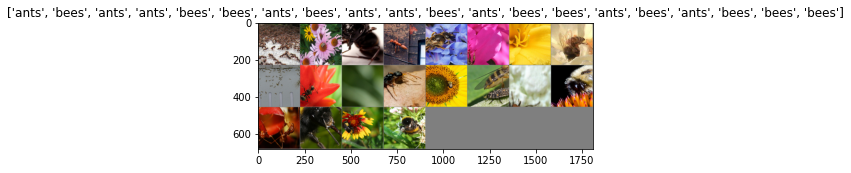

In [10]:
# # Get a batch of training data
# inputs, labels = next(iter(train_loader))
# # Make a grid from batch
# output = torchvision.utils.make_grid(inputs)
# imshow(output, title=[classes[x] for x in labels])

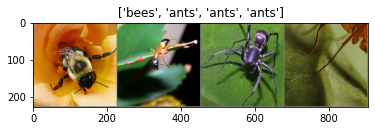

In [8]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
output = torchvision.utils.make_grid(inputs)

imshow(output, title=[class_names[x] for x in classes])

# Trainng Model

In [9]:
# train model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Load Pretrained Model

In [10]:
model = torchvision.models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
model = train_model(model, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.6741 Acc: 0.5861
val Loss: 0.2027 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.5057 Acc: 0.7951
val Loss: 0.2423 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.4566 Acc: 0.8197
val Loss: 0.7603 Acc: 0.7255

Epoch 3/24
----------
train Loss: 0.4632 Acc: 0.7992
val Loss: 0.2283 Acc: 0.9020

Epoch 4/24
----------
train Loss: 0.5559 Acc: 0.7746
val Loss: 0.1982 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.6046 Acc: 0.7541
val Loss: 0.1861 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.4790 Acc: 0.7951
val Loss: 0.1590 Acc: 0.9542

Epoch 7/24
----------
train Loss: 0.3645 Acc: 0.8484
val Loss: 0.2184 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.3419 Acc: 0.8607
val Loss: 0.1797 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.2677 Acc: 0.8975
val Loss: 0.1578 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.3481 Acc: 0.8197
val Loss: 0.1855 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.4070 Acc: 0.8197
val Loss: 0.1876 Acc: 0.9281

Epoch 12/24
----------
t

# Visualize Sample Test Results

In [ ]:
# obtain one batch of test images
# dataiter = iter(test_loader)
inputs, labels = next(iter(test_loader))
inputs.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    inputs = inputs.cuda()

# get sample outputs
output = model(inputs)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(inputs[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))